# 패키지 설치하기

In [1]:
!pip install -e git+https://github.com/judy3378/ratsnlp.git@get_trainer#egg=ratsnlp

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Obtaining ratsnlp from git+https://github.com/judy3378/ratsnlp.git@get_trainer#egg=ratsnlp
  Updating ./src/ratsnlp clone (to revision get_trainer)
  Running command git fetch -q --tags
  Running command git reset --hard -q 9590bc1370a84be1e335df1a4c8cd8819b56e847
  Preparing metadata (setup.py) ... done
DEPRECATION: pytorch-lightning 1.6.1 has a non-standard dependency specifier torch>=1.8.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: ratsnlp
    Found existing installation: ratsnlp 1.0.53
    Uninstalling ratsnlp-1.0.53:
      Successfully uninstalled ratsnlp-1.0.53
  Running setup.py develop for ratsnlp
Note: you may need to restart the kernel to use upda

In [13]:
import os, csv, torch,sys
import pandas, json
import matplotlib.pyplot as plt
%matplotlib inline

# 각종 설정
모델 하이퍼파라메터(hyperparameter)와 저장 위치 등 설정 정보를 선언합니다.

## args 설정

arguments.py 의 ClassificationTrainArguments 클래스를 불러옵니다. '@dataclass' 데코레이터를 사용하여 정의된 학습에 필요한 다양한 설정의 속성들을 지정합니다.

- pretrained_model_name: 사전 학습된 모델의 이름을 지정합니다.
- downstream_corpus_name: 학습에 사용될 데이터가 있는 디렉토리 이름을 지정합니다.
- downstream_corpus_root_dir: 학습 데이터가 위치한 루트 디렉토리 경로를 지정합니다.
- downstream_model_dir: 학습된 모델을 저장할 디렉토리 경로를 지정합니다.
- batch_size: 배치 크기를 지정합니다. 0이면 PyTorch Lightning이 최적의 배치 크기를 찾습니다.
- learning_rate: 학습률을 지정합니다.
- max_seq_length: 토크나이징 후의 최대 입력 시퀀스 길이를 지정합니다.
- epochs: 최대 에포크 수를 지정합니다.
- seed: 랜덤 시드를 지정합니다.

여기서 지정하지 않은 속성들은 default값으로 수행합니다.

In [9]:
from ratsnlp.nlpbook.classification.arguments import ClassificationTrainArguments

args = ClassificationTrainArguments(
    pretrained_model_name="beomi/kcbert-base",
    downstream_corpus_name="report", #학습 데이터가 있는 디렉토리 이름으로 설정.
    downstream_corpus_root_dir="/data/intern_task5/task12/version01/", #학습 데이터가 있는 root directory. 
    downstream_model_dir = os.path.abspath("test07"), #학습된 모델을 저장할 디렉토리 이름으로 설정.
    batch_size=512 if torch.cuda.is_available() else 4, 
    learning_rate=5e-5,
    max_seq_length=256, # 배치당 토큰 길이 제한
    epochs=79,
    # tpu_cores=0 if torch.cuda.is_available() else 8,
    seed=7,
)

In [10]:
print(args)

ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_task_name='document-classification', downstream_corpus_name='report', downstream_corpus_root_dir='/data/intern_task5/task12/version01/', downstream_model_dir='/data/intern_task5/task12/version01/test07', max_seq_length=256, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=79, batch_size=512, cpu_workers=128, fp16=False, tpu_cores=0)


## args default 값

- save_top_k = 1: 최상위 k 개의 모델 체크포인트를 저장합니다. 본 모델은 loss 값이 제일 낮은 epoch을 저장합니다.
- monitor = 'min val_loss': 모니터링 조건을 지정하여 최상위 모델을 저장합니다.
- overwrite_cache = False: 캐시된 학습 및 평가 데이터를 덮어쓸지 여부를 지정합니다.
- cpu_workers = os.cpu_count():
- force_download = False: 데이터와 사전 학습된 모델을 강제로 다운로드할지 여부를 지정합니다. 
- test_mode = False: 테스트 모드를 활성화하여 fast_dev_run을 사용할지 여부를 지정합니다. 
- fp16 = False: fp16 형식으로 학습을 활성화할지 여부를 지정합니다.
- tpu_cores = 0: tpu를 사용할 코어 수를 지정합니다.


## 랜덤 시드 고정
학습 재현을 위해 랜덤 시드를 고정합니다.

In [11]:
from ratsnlp import nlpbook
nlpbook.utils.set_seed(args)

set seed: 7


## 로거 설정
메세지 출력 등을 위한 logger를 설정합니다.

In [12]:
#각종 로그들을 출력하는 로거
nlpbook.utils.set_logger(args)

INFO:ratsnlp:Training/evaluation parameters ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_task_name='document-classification', downstream_corpus_name='report', downstream_corpus_root_dir='/data/intern_task5/task12/version01/', downstream_model_dir='/data/intern_task5/task12/version01/test07', max_seq_length=256, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=79, batch_size=512, cpu_workers=128, fp16=False, tpu_cores=0)


# 데이터 셋 불러오기
학습에 사용할 데이터셋을 불러옵니다. 'train.json, valid.json, test.json' 중 선택합니다.

In [8]:
from ratsnlp.nlpbook.classification.corpus import ClassificationExample, NsmcCorpus

corpus = NsmcCorpus()

# Usage example
mode = "train" # 'valid', 'test' 모드 설정 가능.
data_root_path ='/data/intern_task5/task12/version01/report'  # 학습을 위한 데이터가 저장된 루트 경로를 지정합니다.
examples_list = corpus.get_examples(data_root_path, mode) #'NsmcCorpus'의 'get_examples' 메서드를 사용하여 데이터내 원문에 해당하는 내용을 (text_a) 가져옵니다.


# Print the first few examples for verification
for example in examples_list[:2]:
    print(f"text_a: {example.text_a}, label: {example.label}")


text_a: 보수진영 사분오열 속 ‘국민통합연대’ 띄운 비박계 크리스마스를 앞둔 지난 23일 오전 서울 프레스센터 국제회의실.
  보수분열 극복을 내건 ‘국민통합연대’가 창립대회를 열었다.
  햇살 없이 착 가라앉은 날씨에 동지 바람이 매서웠지만 행사장 안은 달아올랐다.
  문재인 정권을 향한 맹폭격이 이어졌고 ‘무능, 기만의 오만방자한 정권에 사망을 선고한다’는 창립선언문이 나왔다.
  홍준표 전 자유한국당 대표 등 전현직 의원 20여명을 포함해 500여명이 자리를 빼곡하게 메웠다.
  총선이 불과 석달 남짓이다.
  야권 인사들이 정권을 두들겨 패는 거야 이상한 일이 아니다.
  눈 여겨 볼 대목은 모인 사람이 대부분 친이·비박계(친이명박·비박근혜) 인사들이란 점이다.
  박관용 전 국회의장, 이문열 작가와 함께 보수쪽 명망가 여럿이 이름을 올리고 더러 참석했다.
  전광훈 목사는 축사를 했다.
  그래도 이명박 정권서 요직을 맡았던 사람들이 주축이다.
  이재오 중앙집행위원장과 홍준표 전 대표가 한가운데 있다.
  두 사람은 ‘친박 그룹’에 둘러싸인 황교안 대표와 한국당에 불편한 기색을 감추지 않는 중이다.
  홍 전 대표는 이튿날 “무기력한 야당만 믿고 따르기엔 너무 답답하고 앞날이 보이지 않아 창립한 게 국민통합연대”란 글을 올렸다.
  31일엔 “한국당 지도부는 총사퇴하고 비상대책위를 꾸려야 한다”고 황 대표 사퇴를 요구했다.
  이재오 위원장은 지난 10월3일 광화문의 조국 규탄집회장에서 “자유한국당은 집회에서 빠지라”고 외쳤다.
  가뜩이나 뿔뿔이 흩어진 각자도생의 보수세력이다.
  한국당과 우리공화당에다 새로운 보수당, 이언주 신당, 이정현 신당이 나올 판이다.
  게다가 개정선거법의 준연동형 비례대표제는 군소정당에 유리한 분열요인이다.
  중앙선관위에 등록된 정당이 34개인데 창당준비위원회를 설립한 예비정당만 16개에 달한다.
  야권 빅텐트를 외칠만한 상황이긴 하다.
  그런데 통합을 내건 이재오 위원장은 “어느 한 정당이나 단체 중 힘 

# 토크나이저 준비
토큰화를 수행하는 토크나이저를 선언합니다.

- kcbert의 Tokenizer는 Huggingface의 Tokenizers 라이브러리를 통해 학습을 진행했습니다. 그 중 BertWordPieceTokenizer 를 이용해 학습을 진행했고, Vocab Size는 30000으로 진행했습니다. Tokenizer를 학습하는 것에는 1/10로 샘플링한 데이터로 학습을 진행했고, 보다 골고루 샘플링하기 위해 일자별로 stratify를 지정한 뒤 학습을 진행했습니다. [github.com/Beomi/KcBERT 참고]

In [8]:
#토크나이저 준비하기
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    'beomi/kcbert-base',
    do_lower_case=False,
)

In [9]:
print(tokenizer.tokenize("안녕하세요. 반갑습니다."))

['안녕', '##하세요', '.', '반', '##갑', '##습니다', '.']


# 학습데이터 구축
학습데이터를 만듭니다.

In [10]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from ratsnlp.nlpbook.classification import NsmcCorpus, ClassificationDataset

print(corpus.get_labels()) #학습데이터 레이블을 확인합니다.

train_dataset = ClassificationDataset(
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode="train",
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    sampler=RandomSampler(train_dataset, replacement=False),
    collate_fn=nlpbook.data_collator,
    drop_last=False,
    num_workers=args.cpu_workers,
)

INFO:ratsnlp:Loading features from cached file /data/intern_task5/task12/report/cached_train_BertTokenizer_256_report_document-classification [took 10.474 s]


# 테스트 데이터 구축
학습 중에 평가할 테스트 데이터를 구축합니다.

In [11]:
val_dataset = ClassificationDataset(
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode="test",
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=args.batch_size,
    sampler=SequentialSampler(val_dataset),
    collate_fn=nlpbook.data_collator,
    drop_last=False,
    num_workers=args.cpu_workers,
)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


INFO:ratsnlp:Loading features from cached file /data/intern_task5/task12/report/cached_test_BertTokenizer_256_report_document-classification [took 1.070 s]


# 모델 초기화
프리트레인이 완료된 BERT 모델을 읽고, 문서 분류를 수행할 모델을 초기화합니다.

In [12]:
# BertForSequenceClassification
#  - 프리트레인 BERT모델 위에 태스크 모듈이 합쳐진 모델 클래스
from transformers import BertConfig, BertForSequenceClassification
pretrained_model_config = BertConfig.from_pretrained(
    args.pretrained_model_name,
    num_labels=corpus.num_labels,
)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 10 µs


In [13]:
model = BertForSequenceClassification.from_pretrained(
        args.pretrained_model_name,
        config=pretrained_model_config,
)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

# 학습 준비
Task와 Trainer를 준비합니다.

In [14]:
# pytorch lightning이 제공하는 LightningModule 클래스를 상속받아 태스크를 정의
# ClassificationTask에는 Optimizer, learning rate scheduler 가 정의
# Optimizer = Adam , learning rate scheduler = ExponentialLR
from ratsnlp.nlpbook.classification import ClassificationTask
task = ClassificationTask(model, args)

In [15]:
from ratsnlp.nlpbook.classification.task import MetricsHistoryCallback
history_callback = MetricsHistoryCallback()

In [16]:
# pytorch lightning 라이브러리의 도움을 받아 각종 설정을 자동으로 해주는 코드
%time
trainer = nlpbook.get_trainer(args)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 15.5 µs


In [17]:
trainer.callbacks.append(history_callback)

# 학습
준비한 데이터와 모델로 학습을 시작합니다. 학습 결과물(체크포인트)은 위 args에 정의해둔 downstream_model_dir에 저장됩니다.

In [ ]:
%time
trainer.fit(
    task,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

/root/miniconda3/envs/task12/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
Missing logger folder: /data/intern_task5/task12/test07/lightning_logs


CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 12.4 µs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/root/miniconda3/envs/task12/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/root/miniconda3/envs/task12/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:380: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'scheduler'}
  rank_zero_warn(

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 108 M 
--------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
435.705   Total estimated model params size (MB)


Epoch 0:  89%|████████▉ | 144/162 [04:24<00:33,  1.84s/it, loss=0.22, v_num=0, acc=0.925] 
Validation: 0it [00:00, ?it/s]
Epoch 1:  89%|████████▉ | 144/162 [09:25<01:10,  3.92s/it, loss=0.158, v_num=0, acc=0.950, val_loss=0.166, val_acc=0.782]  
Validation: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▉ | 144/162 [14:25<01:48,  6.01s/it, loss=0.108, v_num=0, acc=0.952, val_loss=0.141, val_acc=0.799]  
Validation: 0it [00:00, ?it/s]
Epoch 3:  89%|████████▉ | 144/162 [19:24<02:25,  8.09s/it, loss=0.0693, v_num=0, acc=1.000, val_loss=0.165, val_acc=0.835] 
Validation: 0it [00:00, ?it/s]
Epoch 4:  89%|████████▉ | 144/162 [24:20<03:02, 10.14s/it, loss=0.0648, v_num=0, acc=1.000, val_loss=0.181, val_acc=0.792]   
Validation: 0it [00:00, ?it/s]
Epoch 5:  89%|████████▉ | 144/162 [29:21<03:40, 12.24s/it, loss=0.0421, v_num=0, acc=1.000, val_loss=0.179, val_acc=0.797]   
Validation: 0it [00:00, ?it/s]
Epoch 6:  89%|████████▉ | 144/162 [34:21<04:17, 14.31s/it, loss=0.0338, v_num=0, acc=1.000, val_los

In [29]:
# Print the stored metrics
#for epoch, loss, acc in history_callback.train_metrics_per_epoch:
#    print(f"Epoch: {epoch}, Train Loss: {loss}, Train Acc: {acc}")

#for epoch, val_loss, val_acc in history_callback.val_metrics_per_epoch:
#    print(f"Epoch: {epoch}, Val Loss: {val_loss}, Val Acc: {val_acc}")

In [30]:
#history_callback.train_metrics_per_epoch

In [31]:
#history_callback.val_metrics_per_epoch

## acc, loss-epoch 그래프

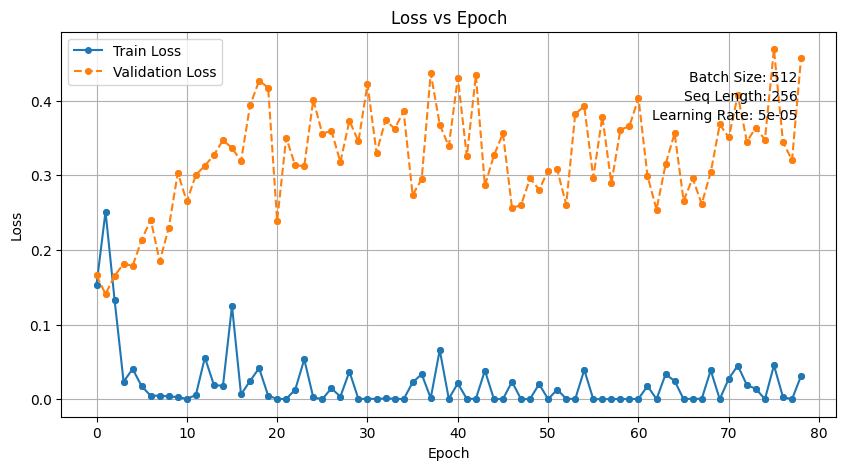

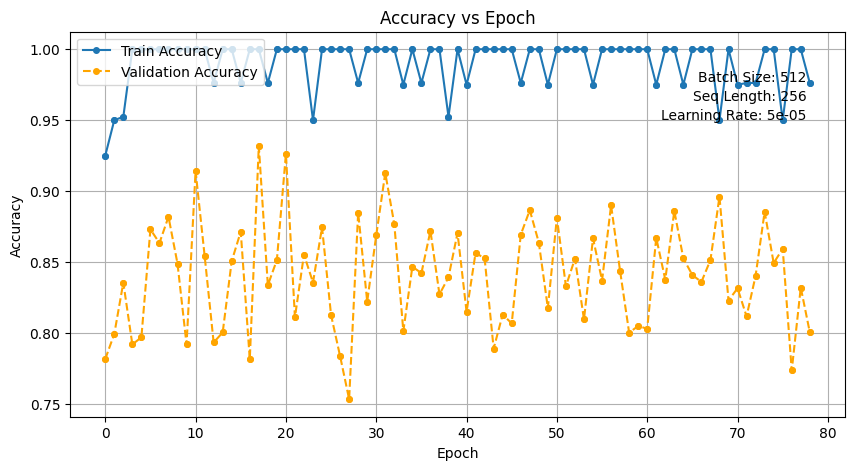

In [43]:
save_directory = 'plots/'
dirname = os.path.basename(args.downstream_model_dir)
#print(dirname)  # This will print "test05"

# Extract data from history_callback
val_epochs = [epoch for epoch, _, _ in history_callback.val_metrics_per_epoch]
train_epochs = [epoch for epoch, _, _ in history_callback.train_metrics_per_epoch]
val_losses = [val_loss.item() for _, val_loss, _ in history_callback.val_metrics_per_epoch]
train_losses = [train_loss.item() for _, train_loss, _ in history_callback.train_metrics_per_epoch]
val_accs = [val_acc.item() for _, _, val_acc in history_callback.val_metrics_per_epoch]
train_accs = [train_acc.item() for _, _, train_acc in history_callback.train_metrics_per_epoch]

# Plot validation loss vs epoch
plt.figure(figsize=(10, 5))

plt.plot(train_epochs, train_losses, marker='o', markersize=4,  label='Train Loss')
plt.plot(val_epochs, val_losses, linestyle='--', marker='o',  markersize=4, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend(loc='upper left')
plt.grid()

# Add batch size and sequence length info as text annotation
plt.text(0.95, 0.9, f'Batch Size: {args.batch_size}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')
plt.text(0.95, 0.85, f'Seq Length: {args.max_seq_length}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')
plt.text(0.95, 0.8, f'Learning Rate: {args.learning_rate}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.savefig(os.path.join(save_directory,f'{dirname}_loss_batch{args.batch_size}_seq{args.max_seq_length}_epoch{args.epochs}_lr{args.learning_rate}.png'))  # Save the plot with dynamic file name

# Plot validation accuracy vs epoch
plt.figure(figsize=(10, 5))

plt.plot(train_epochs, train_accs, marker = 'o',   markersize=4, label='Train Accuracy')
plt.plot(val_epochs, val_accs, linestyle='--', marker='o',   markersize=4, color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend(loc='upper left')
plt.grid()

# Add batch size and sequence length info as text annotation
plt.text(0.95, 0.9, f'Batch Size: {args.batch_size}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')
plt.text(0.95, 0.85, f'Seq Length: {args.max_seq_length}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')
plt.text(0.95, 0.8, f'Learning Rate: {args.learning_rate}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.savefig(os.path.join(save_directory,f'{dirname}_acc_batch{args.batch_size}_seq{args.max_seq_length}_epoch{args.epochs}_lr{args.learning_rate}.png'))  # Save the plot with dynamic file name


## csv 로 저장

In [34]:
# Save loss and accuracy information in a CSV file
csv_file_path = os.path.join('train_result_csv/', f'loss_acc_info_batch{args.batch_size}_seq{args.max_seq_length}_epoch{args.epochs}_lr{args.learning_rate}_test05.csv')
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Batch Size', 'Max Seq Length', 'Epochs', 'Learning Rate'])
    csv_writer.writerow([args.batch_size, args.max_seq_length, args.epochs, args.learning_rate])
    csv_writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy'])
    for epoch, train_loss, train_acc, val_loss, val_acc in zip(train_epochs, train_losses, train_accs, val_losses, val_accs):
        csv_writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])

## 학습 히스토리

- 마지막 epoch의 결과값.

In [35]:
# Access the training history
training_history = trainer.logged_metrics
print(training_history)

{'loss': tensor(0.0312), 'acc': tensor(0.9762), 'val_loss': tensor(0.4569), 'val_acc': tensor(0.8005)}


In [36]:
trainer.current_epoch

79

In [37]:
loss_value = training_history['loss'].item()
print(loss_value)
val_loss_value = training_history['val_loss'].item()
print(val_loss_value)
acc_value = training_history['acc'].item()
print(acc_value)
val_acc_value = training_history['val_acc'].item()
print(val_acc_value)

0.031169572845101357
0.456879585981369
0.976190447807312
0.8004953265190125


In [38]:
metrics_to_extract = ['loss', 'acc', 'val_loss', 'val_acc']
metric_values = {metric: training_history[metric].item() for metric in metrics_to_extract}
print(metric_values)


{'loss': 0.031169572845101357, 'acc': 0.976190447807312, 'val_loss': 0.456879585981369, 'val_acc': 0.8004953265190125}


In [29]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "kcbert_classifier_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

NameError: name 'model' is not defined

In [32]:
from transformers import BertConfig, BertForSequenceClassification
pretrained_model_config = BertConfig.from_pretrained(
    args.pretrained_model_name,
    num_labels=corpus.num_labels,
)
ckpt_file_path='intern_task5/task12/version01/test07/epoch=1-val_loss=0.14.ckpt'
model1=BertForSequenceClassification.from_pretrained(
        args.pretrained_model_name,
        config=pretrained_model_config,
)
model2 = model1.load_from_checkpoint(ckpt_file_path)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

AttributeError: 'BertForSequenceClassification' object has no attribute 'load_from_checkpoint'